<a href="https://colab.research.google.com/github/alainevo/cosc2673_a2/blob/main/A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load and Set up


Import libraries

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import os, zipfile
import pathlib
import matplotlib.pyplot as plt

import tensorflow as tf

Check if notebook is running in colab to prepare for dataloading

In [2]:
if os.getenv("COLAB_RELEASE_TAG"):
   InColab = True
else:
   InColab = False
   
if InColab:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


**Load data**


In [3]:
if InColab:
  if pathlib.Path('/dataset').exists():
    !rm -rf /dataset 
  with zipfile.ZipFile('/content/drive/MyDrive/A2/Image_classification_data.zip','r') as zip_ref:
      zip_ref.extractall("/dataset")
      data = pd.read_csv('/dataset/data_labels_mainData.csv')
      data_extra = pd.read_csv('/dataset/data_labels_extraData.csv')

else:
  if pathlib.Path('./dataset').exists():
    !rm -rf ./dataset 
  with zipfile.ZipFile('./Image_classification_data.zip','r') as zip_ref:
      zip_ref.extractall("./dataset")
      data = pd.read_csv('./dataset/data_labels_mainData.csv')
      data_extra = pd.read_csv('./dataset/data_labels_extraData.csv')

Check if the data is loaded properly

In [4]:
data

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0
...,...,...,...,...,...,...
9891,1625,60,1625.png,epithelial,2,1
9892,1626,60,1626.png,epithelial,2,1
9893,1627,60,1627.png,epithelial,2,1
9894,1628,60,1628.png,epithelial,2,1


In [5]:
# from google.colab import drive

# MOUNT_PATH = '/content/drive/'
# PROJECT_DIR = MOUNT_PATH + 'My Drive//'

# drive.mount(MOUNT_PATH)

In [6]:
# data = pd.read_csv(PROJECT_DIR + "data_labels_mainData.csv")
# data_extra = pd.read_csv(PROJECT_DIR + "data_labels_extraData.csv")

In [7]:
# !unzip -n -qq /content/drive/MyDrive/A2/patch_images.zip 

# Task I: Cancerous Cell Classification



## 1. Overview & Objective

## 2. Exploratory Data Analysis


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


**Observation:**
* No missing values
* Data type of cellType and isCancerous are correct

### Identifying Class Imbalance

Plot the graph to show number between cancer patients and non-cancer patients

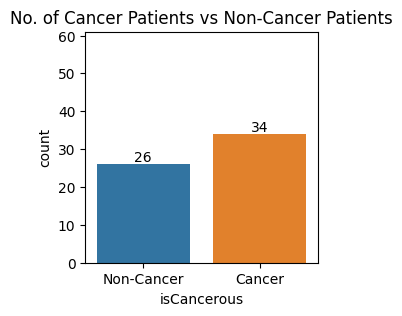

In [9]:
import seaborn as sns

count_cancer_data = data.groupby('patientID')['isCancerous'].nunique().reset_index()
fig = plt.subplots(figsize=(3, 3))

ax = sns.countplot(x ='isCancerous', data = count_cancer_data)
ax.set_ylim([0, max(count_cancer_data['patientID']) + 1])
ax.set_xticklabels(['Non-Cancer', 'Cancer'])
ax.bar_label(ax.containers[0])
plt.title('No. of Cancer Patients vs Non-Cancer Patients')
plt.show()

Plot the number of cancerous cell and non-cancerous cell in the main dataset.

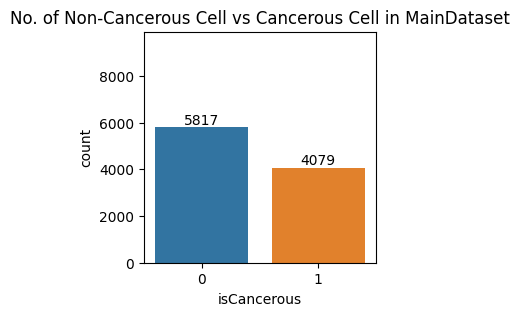

In [10]:
fig = plt.subplots(figsize=(3, 3))
ax = sns.countplot(x ='isCancerous', data = data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
ax.set_ylim([0, data.shape[0]])
ax.bar_label(ax.containers[0])
plt.title('No. of Non-Cancerous Cell vs Cancerous Cell in MainDataset')
plt.show()

As can be seen from the plot above, **the dataset is imbalance** between Cancerous Cell and Non-Cancerous Cell.

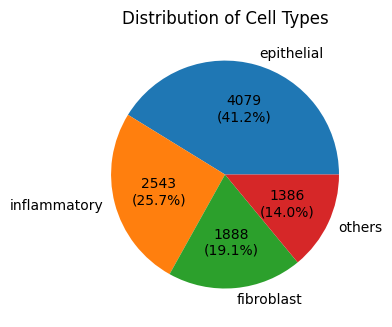

In [11]:
fig = plt.subplots(figsize=(3.7, 3.7))

# Count the occurrences of each cell type
counts = data['cellTypeName'].value_counts().reset_index()

# Rename the columns
counts.columns = ['cellTypeName', 'count']

# Plot the pie chart
plt.pie(counts['count'], labels=counts['cellTypeName'], autopct=lambda x: '{:.0f}\n({:.1f}%)'.format(x * sum(counts['count']) / 100, x))

# Set the title of the plot
plt.title('Distribution of Cell Types')

# Show the plot
plt.show()

From the pie chart above, we can see that the number of Epithelial cells accounts for the majority with 41.2% compared to other cell types such as inflammatory (25.7%), and fibroblast (19.1%), while others cell type only accounts for 14.0% of the total.

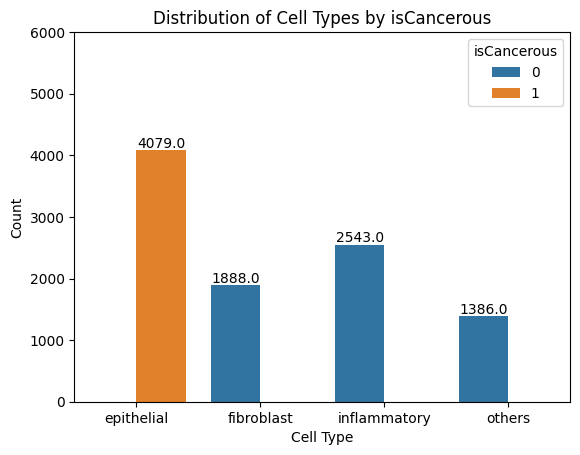

In [12]:
# Group the dataframe by Cell_Type and isCancerous, then calculate the count of each group
counts = data.groupby(['cellTypeName', 'isCancerous']).size().reset_index(name='Count')

# Plot the distribution of cell types by isCancerous attribute
ax = sns.barplot(data=counts, x='cellTypeName', y='Count', hue='isCancerous')

# Add text labels to the bars with the count of each cell type
for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(y, (x, y), ha='center', va='bottom', fontsize=10)

# Set the title of the plot
plt.title('Distribution of Cell Types by isCancerous')

# Set the x label
plt.xlabel('Cell Type')

# Set the y label
plt.ylabel('Count')
ax.set_ylim([0, 6000])

# Show the plot
plt.show()

**Observation:**
* From the chart above, we can see that all cancerous cells have only one type which is Epithelial.
* The number of epithelial cell is also equal to the number of the cancerous cell in the dataset which is both 4079.

➡️ All epithelial cells are cancerous cell.

💡 From this exploration, we can utilize the extra dataset, which only provides the label for isCancerous, to enhance the cell-type classification model later on Task 2. We can assume that all cancerous cells in the extra dataset belong to the Epithelial cell type.

Next, we can check for the extra dataset to have a better understanding before utilizing it for Task 1 (which is classifying a cell is cancerous or not).

**Extra dataset “Data labels extraData.csv” exploration.**

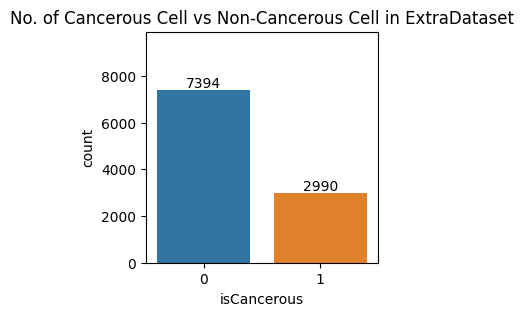

In [13]:
fig = plt.subplots(figsize=(3, 3))
ax = sns.countplot(x ='isCancerous', data = data_extra)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
ax.set_ylim([0, data.shape[0]])
ax.bar_label(ax.containers[0])
plt.title('No. of Cancerous Cell vs Non-Cancerous Cell in ExtraDataset')
plt.show()

**Observation:** The extra dataset has a heavy imbalance between the 2 classes than the main dataset.

Since the datasets are imbalance we must be careful when choose the proper evaluation metrics later on.

### Viewing Image Sampling

1. Distribution of image sizes


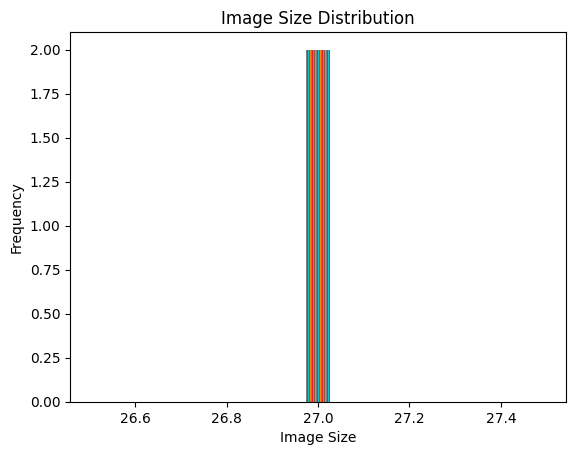

In [14]:
from PIL import Image

# Set the path to the image directory
image_dir = '/dataset/patch_images/'

# Create a list to store the image sizes
image_sizes = []

# Iterate through the dataset and get the size of each image
for img_name in data['ImageName']:
    img_path = os.path.join(image_dir, img_name)
    with Image.open(img_path) as img:
        image_sizes.append(img.size)

# Plot the image size distribution
plt.hist(image_sizes, bins=15)
plt.xlabel('Image Size')
plt.ylabel('Frequency')
plt.title('Image Size Distribution')
plt.show()

The image sizes seem to have the same distribution. Therefore, we do not need to resize the images. Now, we can plot some images for checking it in more detail.

2. Plotting some images:

We can plot some random images of each cell type to get an overview look of them. Also, we can check for any Mislabeling in our image data.


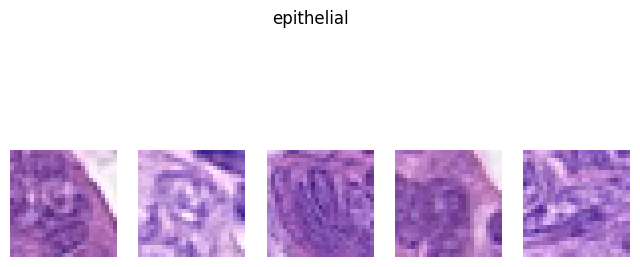

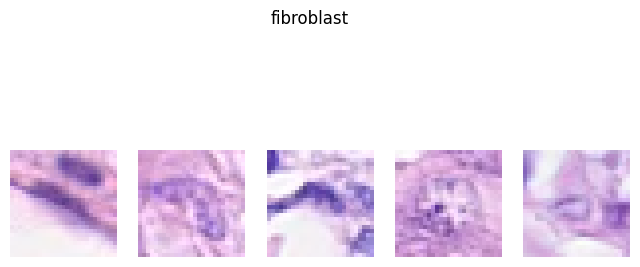

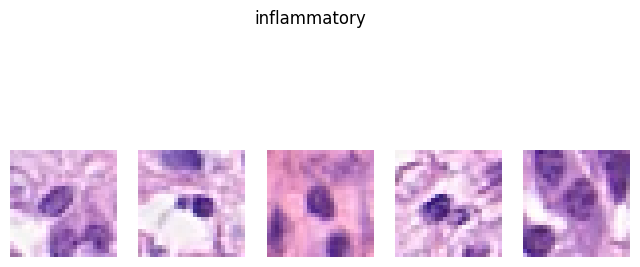

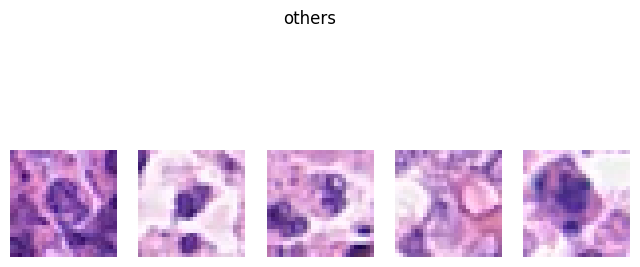

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Group the images by cell type
groups = data.groupby('cellTypeName')

# Select a few images from each group for plotting
n_samples = 5
for cell_type, group in groups:
    sample = group.sample(n=n_samples, replace=True)
    sample_images = []
    for index, row in sample.iterrows():
        filename = row['ImageName']
        filepath = '/dataset/patch_images/' + filename
        image = Image.open(filepath)
        sample_images.append(image)
    
    # Check if any of the images are empty
    if None in sample_images:
        print(f"Warning: Empty images found for cell type {cell_type}")
    
    # Plot the sample images
    if all(sample_images):
        plt.figure(figsize=(8, 4))
        for i, image in enumerate(sample_images):
            plt.subplot(1, n_samples, i+1)
            plt.imshow(image)
            plt.axis('off')
        plt.suptitle(cell_type, fontsize=12)
        plt.show()


For further development of this model, we can collaborate with biological experts to detect if there is any Image Mislabeled and relabel it. In this current project, we may skip this part with the assumption that the dataset does not have Mislabeling Data. 

3. Checking duplicate image

In [16]:
import os
import hashlib
# create a dictionary to store the md5 hashes and corresponding file paths
md5_dict = {}

# create a list to store the filenames of the duplicate images
duplicates = []

# set the path to the image directory
image_dir = '/dataset/patch_images/'

# init the variable to count duplicate
count = 0

# iterate through each image filename in the dataset
for filename in data['ImageName']:
    # search for the image file in the directory
    filepath = os.path.join(image_dir, filename)
    if os.path.isfile(filepath):
        # open the file in binary mode and read its content
        with open(filepath, 'rb') as f:
            content = f.read()
            # compute the md5 hash of the file content
            md5_hash = hashlib.md5(content).hexdigest()
            # check if the hash already exists in the dictionary
            if md5_hash in md5_dict:
                print(f'Duplicate image: {filename}')
                print(f'Original file: {md5_dict[md5_hash]}')
                count += 1
                # add the filename to the list of duplicate images
                duplicates.append(filename)
                duplicates.append(md5_dict[md5_hash])
            else:
                md5_dict[md5_hash] = filepath
    else:
        print(f'File not found: {filename}')

print('>> Number of duplications found: ', count)

Duplicate image: 4971.png
Original file: /dataset/patch_images/4721.png
Duplicate image: 15848.png
Original file: /dataset/patch_images/15799.png
Duplicate image: 18581.png
Original file: /dataset/patch_images/18580.png
>> Number of duplications found:  3


As from above, we found 3 duplications. Let's plot those duplications for detailed exploration. If they are the same, we can keep one and eliminate other. However, since we use hashlib's md5() method to compute the hash of the image, it is likely that 2 different inputs can be resulted in the same hash value.

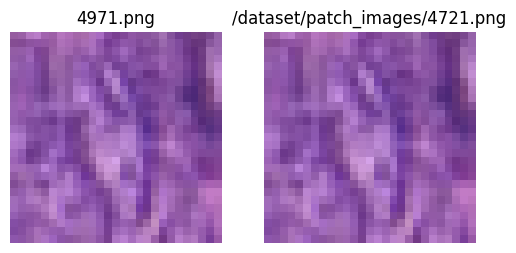

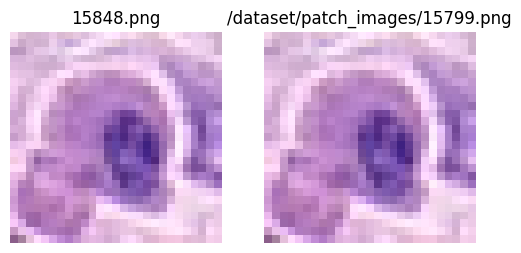

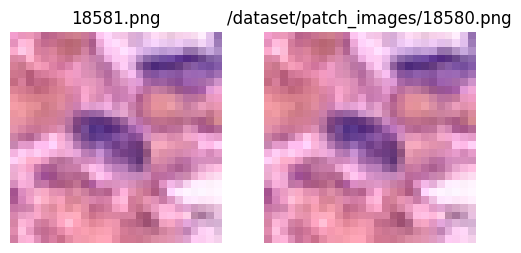

In [17]:
# plot the duplicate images side by side
for i in range(0, len(duplicates), 2):
    filename1 = duplicates[i]
    filepath1 = os.path.join(image_dir, filename1)
    image1 = Image.open(filepath1)
    
    if i+1 < len(duplicates):
        filename2 = duplicates[i+1]
        filepath2 = os.path.join(image_dir, filename2)
        image2 = Image.open(filepath2)
        
        # plot the images side by side
        fig, axs = plt.subplots(1, 2, figsize=(6, 3))
        axs[0].imshow(image1)
        axs[0].set_title(filename1)
        axs[0].axis('off')
        axs[1].imshow(image2)
        axs[1].set_title(filename2)
        axs[1].axis('off')
        plt.show()
    else:
        fig, axs = plt.subplots(1, 1, figsize=(3, 3))
        axs.imshow(image1)
        axs.set_title(filename1)
        axs.axis('off')
        plt.show()

After checking, we can be sure that there are 3 duplications in our dataset images patch. Based on the finding, we will remove the duplicate imnage from the dataset.

It is important to handling duplicate images, since it will help us to avoid any bias when training the model and avoid failing to generalie new data [(Lee, 2021)](https://medium.com/mlearning-ai/a-scalable-solution-to-detect-duplicate-images-97d431c2726d).

In [18]:
# Create a list to store unique images
unique_images = []

# Create a set to store unique hash values
unique_hashes = set()

# Iterate over each image in the directory
for filename in os.listdir(image_dir):
    # Calculate the hash value of the image
    with open(os.path.join(image_dir, filename), 'rb') as f:
        image_hash = hashlib.md5(f.read()).hexdigest()
    
    # Check if the hash value is already in the list of unique hashes
    if image_hash not in unique_hashes:
        # Add the image to the list of unique images
        unique_images.append(filename)
        # Add the hash value to the set of unique hashes
        unique_hashes.add(image_hash)
    else:
        # Delete the duplicate image from the directory
        os.remove(os.path.join(image_dir, filename))

## 3. Preprocessing Data

### Handle Imbalanced Dataset

As explored in the EDA above, we have an imbalanced dataset for the classes: cancerous and non-cancerous cells (isCancerous or not). To tackle this problem, we can try to resample our data.

For this project, since the size of the dataset is not too large, we will not perform undersampling. Instead of that, we can upsample our dataset by adding random duplicate data from the minor class. However, this technique can have one drawback which is causing overfitting to our model. 

To this point, we can think of the extra dataset and use it to add more data for our minor class and make it balanced with the major class.

In [19]:
print("Before balancing the dataset")
isCancerous_count = data.isCancerous.value_counts()
print(isCancerous_count)
print('-------------------------------')
# Balance the dataset
# Calculate the gap between 2 classes
gap = isCancerous_count[0] - isCancerous_count[1]
# Take data from the extra dataset
extra_data_isCancerous = data_extra[data_extra['isCancerous'] == 1].sample(gap)
# Concat the two
data = pd.concat([data, extra_data_isCancerous], ignore_index=True)

print("After balancing the dataset")
data.isCancerous.value_counts()

Before balancing the dataset
0    5817
1    4079
Name: isCancerous, dtype: int64
-------------------------------
After balancing the dataset


0    5817
1    5817
Name: isCancerous, dtype: int64

### Get data for Task 1

For Task 1, which is checking if a cell is cancerous or not, therefore, we only need to keep relevant attributes such as: isCancerous, ImageName

In [20]:
# cancerous_data for Task 1
cancerous_data = data[['ImageName', 'isCancerous']]
cancerous_data.head()

,ImageName,isCancerous
0,22405.png,0
1,22406.png,0
2,22407.png,0
3,22408.png,0
4,22409.png,0


### Data Splitting
Randomly splitting data into train, test, and validation set with the proportion of 60 - 20 - 20 respectively.

In [21]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(cancerous_data, test_size=0.2, random_state=107)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=107)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

# Ref: http://localhost:8888/notebooks/rmit_cosc_2673_2793-2310/labs/week08/Week08_lab_excercises_NN.ipynb

Train data : 6980, Val Data: 2327, Test Data: 2327


In [22]:
train_data.head()

,ImageName,isCancerous
1682,13424.png,0
10307,6570.png,1
3980,9408.png,1
5579,11951.png,1
1781,13528.png,1


### Data Normalization and Data Augmentation
We will use 'ImageDataGenerator' from 'keras.preprocessing.image' to apply augmentation to our data. The function will horizontally flip the photos, adjust their height and width, and rotate them at random. 

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def dataframe_generator(data_fr, x_column="ImageName", y_column="cellTypeName", classes=["epithelial", "fibroblast", "inflammatory", "others"]):
  # Convert the label to string format
  data_fr[y_column] = data_fr[y_column].astype('str')

  # Init default params
  batch_size = 64
  img_size = (27, 27)

  # Define data generators for preprocessing and data augmentation
  data_gen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      validation_split=0.2)

  data_generator = data_gen.flow_from_dataframe(
          dataframe=data_fr,
          directory='/dataset/patch_images',
          x_col=x_column,
          y_col=y_column,
          batch_size=batch_size,
          target_size=img_size,
          class_mode='categorical',
          classes=classes)
  return data_generator

# Ref1: https://viblo.asia/p/tang-cuong-du-lieu-trong-deep-learning-oOVlYe4nl8W
# Ref2: http://localhost:8888/notebooks/rmit_cosc_2673_2793-2310/labs/week09/Week9_lab_exercises.ipynb
# Ref3: https://www.datacamp.com/tutorial/complete-guide-data-augmentation

In [24]:
# Apply datagenerator to train, test, and validation set
train_data_gen = dataframe_generator(train_data, y_column='isCancerous', classes=['0', '1'])
test_data_gen = dataframe_generator(test_data, y_column='isCancerous', classes=['0', '1'])
val_data_gen = dataframe_generator(val_data, y_column='isCancerous', classes=['0', '1'])

Found 6978 validated image filenames belonging to 2 classes.
Found 2326 validated image filenames belonging to 2 classes.
Found 2327 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="ImageName". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="ImageName". These filename(s) will be ignored.
  warnings.warn(


## Model Development

### 1. Determine your goals
* Performance metric
* Target value




### 2. Setup the experiment: 






**Import Libraries**

In [25]:
# Performance Metrics
from keras import backend as K

# Evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

**Set up functions**

In [26]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

# Ref: http://localhost:8888/notebooks/rmit_cosc_2673_2793-2310/labs/week09/Week9_lab_exercises.ipynb

In [ ]:
def fit_model(model, generator, val_generator, epochs = 100, name = 'modelDefaultName', export_dir = './export'):
    # Set up early stopping for all type CNN
    early_stopping = EarlyStopping(monitor='val_accuracy', 
                       mode='max', 
                       verbose=1, 
                       patience=10, 
                       restore_best_weights=True)
    
    model_checkpoint = ModelCheckpoint('{}/model_{}.h5'.format(export_dir, name), 
                         monitor='val_accuracy', 
                         mode='max', 
                         save_best_only=True)

    history = model.fit_generator(generator, validation_data = val_generator, 
                                verbose = 1,
                                epochs = epochs,
                                callbacks=[model_checkpoint,early_stopping]
    )
    
    return history

**Performance Metrics:** set up functions for evaluation. In this project, since we have balanced our dataset, we will use the accuracy metric, together with other metrics such as: precision, recall, and f1 to evaluate the models performance.


In [27]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

# List of the metrics
METRICS = ['accuracy', recall, precision, f1]

# Ref: https://gist.github.com/arnaldog12/5f2728f229a8bd3b4673b72786913252

### Base Model - Neural Networks (MLP)


1. Overview
2. Setup
3. Preprocessing
4. Modeling (compile & train)
5. Incremental change
6. Evaluate the final model


In [28]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 2

In [29]:
import tensorflow as tf

# Define the model architecture
model_NN = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid')
])

In [30]:
model_NN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2187)              0         
                                                                 
 dense (Dense)               (None, 256)               560128    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 560,642
Trainable params: 560,642
Non-trainable params: 0
_________________________________________________________________


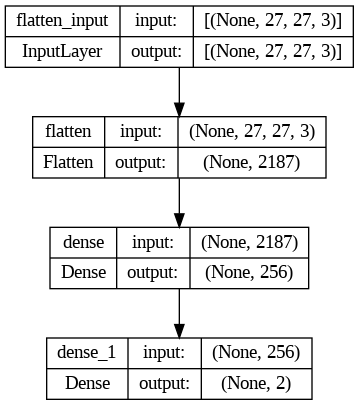

In [31]:
tf.keras.utils.plot_model(model_NN, show_shapes=True)

In [32]:
model_NN.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

In [ ]:
history = model_NN.fit(train_data_gen, validation_data = val_data_gen, epochs=50, verbose=0)

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


In [ ]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['accuracy'], history.history['val_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model_NN.evaluate(train_data_gen)
model_NN.evaluate(val_data_gen)

The validation set score seems to be slightly smaller than the train set score, which indicates our model is a little bit overfit. We can apply some techniques to handle this problem such as: Drop out, or Do some regularization. 

In [ ]:
model_NN_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [ ]:
model_NN_drop.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

In [ ]:
history_drop = model_NN_drop.fit(train_data_gen, validation_data = val_data_gen, epochs=50, verbose=0)

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_drop.history['loss'], 'r--')
plt.plot(history_drop.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_drop.history['accuracy'], 'r--')
plt.plot(history_drop.history['val_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

In [ ]:
model_NN_drop.evaluate(train_data_gen)
model_NN_drop.evaluate(val_data_gen)

After applying "drop out", our model seems to be badly underfit. Therefore, we can adjust the value of drop out and add extra layer to see if we can improve the model performance.

Add 1 extra layer + modified drop out

In [ ]:
# Define the 'model with 1 extra layer' architecture
model_NN_1_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM*(1/3), activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid')
])

# Check model architecture
model_NN_1_drop.summary()

In [ ]:
tf.keras.utils.plot_model(model_NN_1_drop, show_shapes=True)

In [ ]:
# Compile the model
model_NN_1_drop.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
# Fit with the train and val dataset
history_NN_1_drop = model_NN_1_drop.fit(train_data_gen, validation_data=val_data_gen, epochs=50, verbose=0)

In [ ]:
plot_learning_curve(history_NN_1_drop.history['loss'], history_NN_1_drop.history['val_loss'], 
                    history_NN_1_drop.history['accuracy'], history_NN_1_drop.history['val_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
# Evaluate the model
model_NN_1_drop.evaluate(train_data_gen)
model_NN_1_drop.evaluate(val_data_gen)

We can see that after adjusting the drop out value and add more extra layer with the aim to make our model more generalized, however, the model seems to perform badly (accuracy only 50% on both train set and validation set) compared to the default neural networks (84% on train set and 83% on validation set). Therefore, we may keep the default neural networks as our final NN model and then evaluate it on the test set. Next, we can think of building other models to see if it can perform better than the NN one. We can use the evaluation scores we get on the test set to compare those models together. 





#### Evaluation

Testing the final version of neural networks model. 

We now have the final version of neural nertworks. We then use the test dataset to evaluate this model once again and save it for further comparison with other models.

In [ ]:
# Task 1: Neural Networks Evaluation
t1_nn_evaluation = model_NN.evaluate(test_data_gen)

In [ ]:
Y_pred = model_NN.predict(train_data_gen)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(train_data_gen.classes, y_pred))

### Convolutional Neural Network

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras import Input
from keras import Model
from keras.utils import plot_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Add, Flatten, Activation, ZeroPadding2D
from tensorflow.keras import initializers
from keras.initializers import GlorotUniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### ResNet50

In [ ]:
# Ref: https://medium.com/analytics-vidhya/understanding-and-implementation-of-residual-networks-resnets-b80f9a507b9c

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = GlorotUniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = GlorotUniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = GlorotUniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [ ]:
# Ref: https://medium.com/analytics-vidhya/understanding-and-implementation-of-residual-networks-resnets-b80f9a507b9c

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = GlorotUniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    

    # Second component of main path 
    X = Conv2D(F2, (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer=GlorotUniform(seed =0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu') (X)

    # Third component of main path 
    X = Conv2D(F3, (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer=GlorotUniform(seed =0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(F3, (1,1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer=GlorotUniform(seed =0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [ ]:
# Ref: https://medium.com/analytics-vidhya/understanding-and-implementation-of-residual-networks-resnets-b80f9a507b9c

def ResNet50(input_shape = (27, 27, 3), classes = 2):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = initializers.RandomNormal(stddev=0.01))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    X = ZeroPadding2D((1, 1))(X_input)
    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='d')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='e')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='f')

    # Stage 6
    X = convolutional_block(X, f = 3, filters = [1024, 1024, 2048], stage = 6, block='a', s = 2)
    X = identity_block(X, 3, [1024, 1024, 2048], stage=6, block='b')
    X = identity_block(X, 3, [1024, 1024, 2048], stage=6, block='c')
    
    # AVGPOOL . Use "X = AveragePooling2D(...)(X)"
    X = MaxPooling2D()(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', name='fc' + str(classes), kernel_initializer = GlorotUniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
t1_model_resnet50 = ResNet50()
t1_model_resnet50.summary()

# Model Architecture
plot_model(t1_model_resnet50, show_shapes=True)

In [ ]:
# Train model
# Set up optimizer
optimizerr = Adam(lr = 0.0045, amsgrad=True) # set learning rate

# Fit model
history_t1_model_resnet50 = fit_model(t1_model_resnet50, train_data_gen, val_data_gen, name="Task1_Resnet50")

In [ ]:
evaluation_t1_model_resnet50 = t1_model_resnet50.evaluate(test_data_gen)

### GoogLeNet

### AlexNet

## Evaluation

# Task II: Cell-type Classification
